In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('./dataset/Heart.csv')

In [3]:
pd.set_option('display.max_columns', None)  # No limit on number of columns
pd.set_option('display.width', None)        # No width limit for wrapping
pd.set_option('display.max_rows', 500)     # No limit on number of rows (if needed)
pd.set_option('future.no_silent_downcasting', True)  # Opt-in to future behavior

### Removing duplicates.

In [4]:
# Removing duplicates
df = df.drop_duplicates()
print(df.shape)

(444975, 40)


### Logic checks.

In [5]:
# Logic checks
invalid_bmi = df[(df['BMI'] < 10) | (df['BMI'] > 65)]  # BMI typically ranges from 10 to 50
invalid_sleep = df[(df['SleepHours'] < 0) | (df['SleepHours'] > 24)]  # Sleep hours must be 0-24
suspicious_sleep_values = df[(df['SleepHours'] < 3) | (df['SleepHours'] > 22)] #maybe cap as outliers (?)

print(f"Invalid BMI entries: {len(invalid_bmi)}")
print(f"Invalid Sleep Hours entries: {len(invalid_sleep)}")
print(f"Suspicious sleep hours to check again: {len(suspicious_sleep_values)}")

#Creating an Accurate Calculated BMI column
df['CalculatedBMI'] = df['WeightInKilograms'] / (df['HeightInMeters'] ** 2)


#dropping original BMI column
df.drop('BMI', axis=1, inplace=True)

Invalid BMI entries: 364
Invalid Sleep Hours entries: 0
Suspicious sleep hours to check again: 2773


In [6]:
# If AgeCategory is on the older side, they would likely report having at least one of the following: Heart Attack, Stroke, or Diabetes
# These are labelled 'inconsistencies' but it's not a problem, more of a heads-up for me
age_category_inconsistencies = df[
    df['AgeCategory'].isin(['Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older']) & 
    ~(df[['HadHeartAttack', 'HadStroke', 'HadDiabetes']].any(axis=1))  # None of these is True
]
print(f"Number of inconsistencies with Age Category logic (age 60+ but no major health conditions): {len(age_category_inconsistencies)}")


# If SmokerStatus is 'Yes', they should likely report at least one of these conditions
smoker_inconsistencies = df[
    df['SmokerStatus'].isin(['Former Smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day']) & 
    ~(df[['HadHeartAttack', 'HadCOPD', 'HadAsthma', 'HadStroke']].any(axis=1))  # None of these is True
]
print(f"Number of inconsistencies with Smoking status logic (smoker but no major related health conditions): {len(smoker_inconsistencies)}")


# If DifficultyWalking is True, then at least one of DifficultyDressingBathing or DifficultyErrands should also be True
walking_inconsistencies = df[
    (df['DifficultyWalking'] == True) & 
    ~(df[['DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  
]
print(f"Number of inconsistencies with Walking Difficulty logic (difficulty walking but no related difficulties): {len(walking_inconsistencies)}")


# If HadCOPD is True, then at least one of these three difficulties should also be True
copd_inconsistencies = df[
    (df['HadCOPD'] == True) & 
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # At least one difficulty should be True
]
print(f"Number of inconsistencies with COPD logic (COPD but no difficulties with daily activities): {len(copd_inconsistencies)}")


# If HadHeartAttack is True, then at least one of Stroke, Angina, or ChestScan should be True
heart_attack_inconsistencies = df[
    (df['HadHeartAttack'] == True) & 
    ~(df[['HadStroke', 'HadAngina', 'ChestScan']].any(axis=1))  # None of these is True
]
print(f"Number of inconsistencies with Heart Attack logic (Heart Attack but no related conditions reported): {len(heart_attack_inconsistencies)}")


# If SleepHours is less than 4 or more than 12, we expect at least one of the health conditions to be True
sleep_hours_inconsistencies = df[
    ((df['SleepHours'] < 4) | (df['SleepHours'] > 12)) & 
    ~(df[['HadHeartAttack', 'HadAngina', 'HadStroke', 'HadSkinCancer', 'HadAsthma', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DifficultyConcentrating', 'HighRiskLastYear']].any(axis=1))  # None of these is True
]
print(f"Number of inconsistencies with Sleep Hours logic (abnormal sleep but no related health conditions): {len(sleep_hours_inconsistencies)}")


# If PhysicalHealthDays is 0, they should not report significant limitations in daily activities
physical_health_inconsistencies = df[
    (df['PhysicalHealthDays'] == 0) & 
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # No difficulty reported
]
print(f"Number of inconsistencies with Physical Health Days logic (0 health days but activity limitations): {len(physical_health_inconsistencies)}")

Number of inconsistencies with Age Category logic (age 60+ but no major health conditions): 45
Number of inconsistencies with Smoking status logic (smoker but no major related health conditions): 17
Number of inconsistencies with Walking Difficulty logic (difficulty walking but no related difficulties): 0
Number of inconsistencies with COPD logic (COPD but no difficulties with daily activities): 0
Number of inconsistencies with Heart Attack logic (Heart Attack but no related conditions reported): 0
Number of inconsistencies with Sleep Hours logic (abnormal sleep but no related health conditions): 4
Number of inconsistencies with Physical Health Days logic (0 health days but activity limitations): 14233


### Address missing values.

In [7]:
print("Missing values before imputation:\n", df.isnull().sum())

Missing values before imputation:
 State                            0
Sex                              0
GeneralHealth                 1193
PhysicalHealthDays           10922
MentalHealthDays              9062
LastCheckupTime               8301
PhysicalActivities            1088
SleepHours                    5448
RemovedTeeth                 11355
HadHeartAttack                3060
HadAngina                     4400
HadStroke                     1552
HadAsthma                     1768
HadSkinCancer                 3138
HadCOPD                       2214
HadDepressiveDisorder         2807
HadKidneyDisease              1921
HadArthritis                  2628
HadDiabetes                   1082
DeafOrHardOfHearing          20502
BlindOrVisionDifficulty      21419
DifficultyConcentrating      24095
DifficultyWalking            23867
DifficultyDressingBathing    23770
DifficultyErrands            25511
SmokerStatus                 35316
ECigaretteUsage              35514
ChestScan           

In [8]:
# Calculate missing values for all numerical columns
missing_numerical = df.select_dtypes(include=['float64', 'int64']).isna().sum()

# Calculate the total number of rows in the dataframe
total_rows = len(df)

# Calculate the missing percentage for each numerical column
missing_percentage = (missing_numerical / total_rows) * 100

# Combine the results into a DataFrame
missing_numerical_info = pd.DataFrame({
    'Total Missing': missing_numerical,
    'Missing Percentage': missing_percentage
})


print("Missing values in numerical columns:")
print(missing_numerical_info)

Missing values in numerical columns:
                    Total Missing  Missing Percentage
PhysicalHealthDays          10922            2.454520
MentalHealthDays             9062            2.036519
SleepHours                   5448            1.224338
HeightInMeters              28505            6.405978
WeightInKilograms           41931            9.423226
CalculatedBMI               46421           10.432271


All columns printed except for CalculatedBMI can have their missing values imputed normally with median. Since CaluclatedBMI has >10% missing values, we can impute only its values with KNN Imputation.

#### Imputation of below_threshold_numerical_columns

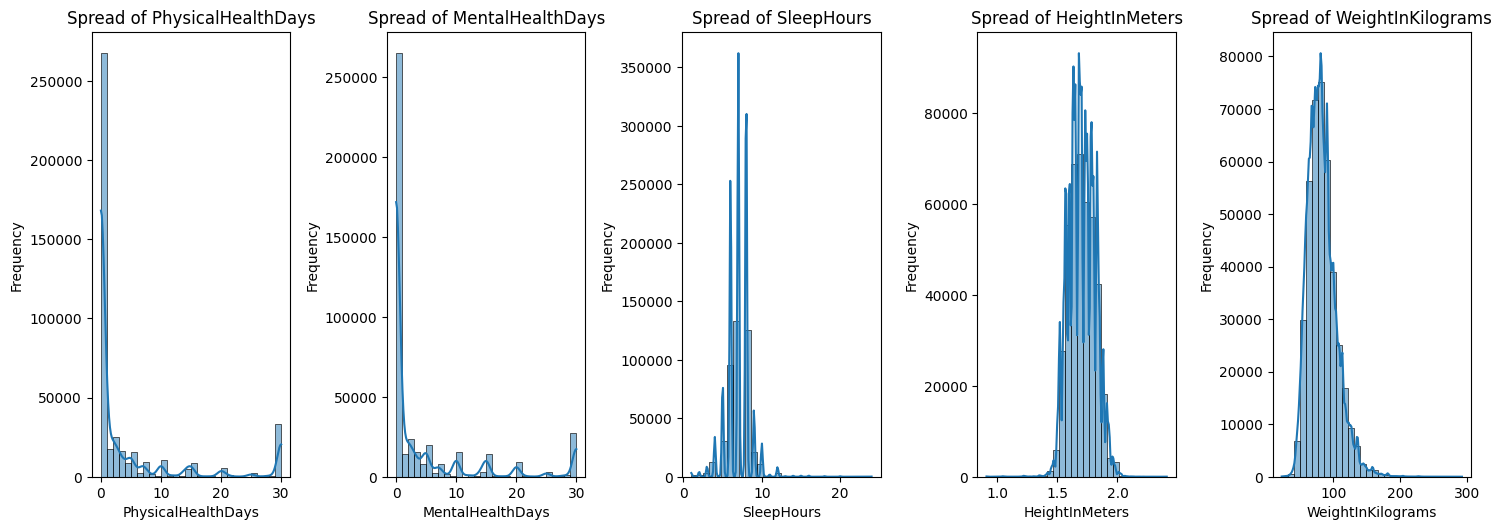

In [9]:
# checking whether these numerical columns have a normal distribution
numerical_columns_to_check = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns_to_check, 1):
    plt.subplot(2, 5, i)  # 1 rows and 5 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Spread of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Only HeightInMetres has a normal distribution - so this one will be imputed with mean instead of median like the others. 

In [10]:
# Impute missing values for numerical columns (except 'HeightInMeters')
numerical_cols = df.select_dtypes('float64').columns.difference(['HeightInMeters'])
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Impute missing values for 'HeightInMeters' with the mean
df['HeightInMeters'] = df['HeightInMeters'].fillna(df['HeightInMeters'].mean())

##### Imputation of above_threshold_numerical_columns

In [11]:
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the 'CalculatedBMI' column
df[['CalculatedBMI']] = knn_imputer.fit_transform(df[['CalculatedBMI']])

##### Imputation of categorical columns

In [12]:
# Identify Categorical Columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Calculate Missing Values for Categorical Columns
missing_categorical = df[categorical_cols].isna().sum()

# Calculate Missing Percentage (for categorical columns only)
total_rows = len(df)
missing_percentage_categorical = (missing_categorical / total_rows) * 100

# Create DataFrame with Missing Info
missing_categorical_info = pd.DataFrame({
    'Total Missing': missing_categorical,
    'Missing Percentage': missing_percentage_categorical.round(2)
})

# Filter only columns with missing data
missing_categorical_info = missing_categorical_info[missing_categorical_info['Total Missing'] > 0]

# Display Missing Values for Categorical Columns
print('Missing values in categorical columns:')
print(missing_categorical_info)

Missing values in categorical columns:
                           Total Missing  Missing Percentage
GeneralHealth                       1193                0.27
LastCheckupTime                     8301                1.87
PhysicalActivities                  1088                0.24
RemovedTeeth                       11355                2.55
HadHeartAttack                      3060                0.69
HadAngina                           4400                0.99
HadStroke                           1552                0.35
HadAsthma                           1768                0.40
HadSkinCancer                       3138                0.71
HadCOPD                             2214                0.50
HadDepressiveDisorder               2807                0.63
HadKidneyDisease                    1921                0.43
HadArthritis                        2628                0.59
HadDiabetes                         1082                0.24
DeafOrHardOfHearing                20502      

In [13]:
# Separate Categorical Columns into "Manageable" and "High" Missing Categories
threshold = 10  # 10% threshold
manageable_missing_cols = missing_categorical_info[missing_categorical_info['Missing Percentage'] < threshold].index.tolist()
high_missing_cols = missing_categorical_info[missing_categorical_info['Missing Percentage'] >= threshold].index.tolist()

print("\nManageable Missing Columns (categorical):", manageable_missing_cols)
print("\nHigh Missing Columns (categorical):", high_missing_cols)

# Impute Manageable Missing Columns with Mode
for col in manageable_missing_cols:
    # Add a missing indicator column before imputation for latder eda
    indicator_col = f"{col}_missing_indicator"
    df[indicator_col] = df[col].isna().astype(int)  # 1 if value is missing, 0 otherwise
    
    # Impute with mode
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)

# Impute High Missing Columns with Mode and Add Missing Indicator Columns
for col in high_missing_cols:
    # Add a missing indicator column before imputation
    indicator_col = f"{col}_missing_indicator"
    df[indicator_col] = df[col].isna().astype(int)  # 1 if value is missing, 0 otherwise
    
    # Impute the original column with mode
    mode_value = df[col].mode().iloc[0]  # Get the most frequent value
    df[col] = df[col].fillna(mode_value)  # Impute with mode value

# Final Summary
print("\nMissing data handling for categorical columns completed.")
print(f"DataFrame now has {df.shape[1]} columns (including missing indicators).")



Manageable Missing Columns (categorical): ['GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory']

High Missing Columns (categorical): ['ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']

Missing data handling for categorical columns completed.
DataFrame now has 72 columns (including missing indicators).


In [14]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,CalculatedBMI,GeneralHealth_missing_indicator,LastCheckupTime_missing_indicator,PhysicalActivities_missing_indicator,RemovedTeeth_missing_indicator,HadHeartAttack_missing_indicator,HadAngina_missing_indicator,HadStroke_missing_indicator,HadAsthma_missing_indicator,HadSkinCancer_missing_indicator,HadCOPD_missing_indicator,HadDepressiveDisorder_missing_indicator,HadKidneyDisease_missing_indicator,HadArthritis_missing_indicator,HadDiabetes_missing_indicator,DeafOrHardOfHearing_missing_indicator,BlindOrVisionDifficulty_missing_indicator,DifficultyConcentrating_missing_indicator,DifficultyWalking_missing_indicator,DifficultyDressingBathing_missing_indicator,DifficultyErrands_missing_indicator,SmokerStatus_missing_indicator,ECigaretteUsage_missing_indicator,RaceEthnicityCategory_missing_indicator,AgeCategory_missing_indicator,ChestScan_missing_indicator,AlcoholDrinkers_missing_indicator,HIVTesting_missing_indicator,FluVaxLast12_missing_indicator,PneumoVaxEver_missing_indicator,TetanusLast10Tdap_missing_indicator,HighRiskLastYear_missing_indicator,CovidPos_missing_indicator
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,1.70269,80.74,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,27.353965,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.60000,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,26.578125,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57000,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,25.761694,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 65 to 69,1.65000,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,23.324151,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57000,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,21.899469,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df.isnull().sum()

State                                          0
Sex                                            0
GeneralHealth                                  0
PhysicalHealthDays                             0
MentalHealthDays                               0
LastCheckupTime                                0
PhysicalActivities                             0
SleepHours                                     0
RemovedTeeth                                   0
HadHeartAttack                                 0
HadAngina                                      0
HadStroke                                      0
HadAsthma                                      0
HadSkinCancer                                  0
HadCOPD                                        0
HadDepressiveDisorder                          0
HadKidneyDisease                               0
HadArthritis                                   0
HadDiabetes                                    0
DeafOrHardOfHearing                            0
BlindOrVisionDifficu

### Cap outliers

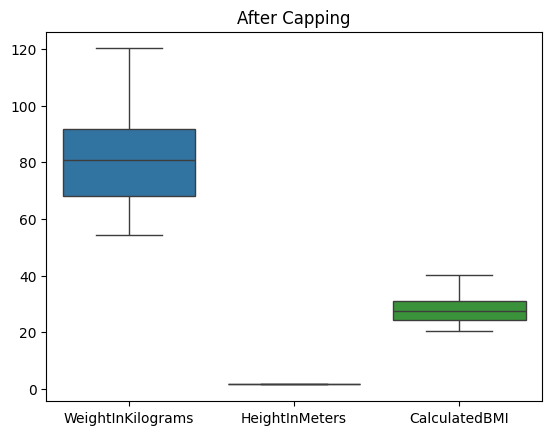

State                                           object
Sex                                             object
GeneralHealth                                   object
PhysicalHealthDays                             float64
MentalHealthDays                               float64
LastCheckupTime                                 object
PhysicalActivities                              object
SleepHours                                     float64
RemovedTeeth                                    object
HadHeartAttack                                  object
HadAngina                                       object
HadStroke                                       object
HadAsthma                                       object
HadSkinCancer                                   object
HadCOPD                                         object
HadDepressiveDisorder                           object
HadKidneyDisease                                object
HadArthritis                                    object
HadDiabete

In [16]:
def cap_outliers(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    for column in columns:
        lower_bound = df[column].quantile(lower_percentile)
        upper_bound = df[column].quantile(upper_percentile)
        
        # Apply capping
        df[column] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound))
    
    return df

# List of columns to cap
columns_to_cap = ['WeightInKilograms', 'HeightInMeters', 'CalculatedBMI']
# sleephours is no longer being capped - removed it from this section

# Apply the capping
df_cleaned = cap_outliers(df, columns_to_cap)

# Verification of capping
sns.boxplot(data=df_cleaned[columns_to_cap])
plt.title("After Capping")
plt.show()

df.dtypes

### Clean up language

##### Strip whitespace + make into lowercase.

In [17]:
for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].str.strip().str.lower()

##### Simplify the values in RaceEthnicityCategory column.

In [18]:
rename_race_ethnicity = {
    'white only, non-hispanic': 'white', 
    'black only, non-hispanic': 'black', 
    'multiracial, non-hispanic': 'multiracial', 
    'other race only, non-hispanic': 'others', 
    'hispanic': 'hispanic'
}

df_cleaned['RaceEthnicityCategory'] = df_cleaned['RaceEthnicityCategory'].replace(rename_race_ethnicity)

### Save to cleaned csv file.

In [19]:
df_cleaned.to_csv('./dataset/Heart_cleaned.csv', index=False)

In [20]:
df_cleaned.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,CalculatedBMI,GeneralHealth_missing_indicator,LastCheckupTime_missing_indicator,PhysicalActivities_missing_indicator,RemovedTeeth_missing_indicator,HadHeartAttack_missing_indicator,HadAngina_missing_indicator,HadStroke_missing_indicator,HadAsthma_missing_indicator,HadSkinCancer_missing_indicator,HadCOPD_missing_indicator,HadDepressiveDisorder_missing_indicator,HadKidneyDisease_missing_indicator,HadArthritis_missing_indicator,HadDiabetes_missing_indicator,DeafOrHardOfHearing_missing_indicator,BlindOrVisionDifficulty_missing_indicator,DifficultyConcentrating_missing_indicator,DifficultyWalking_missing_indicator,DifficultyDressingBathing_missing_indicator,DifficultyErrands_missing_indicator,SmokerStatus_missing_indicator,ECigaretteUsage_missing_indicator,RaceEthnicityCategory_missing_indicator,AgeCategory_missing_indicator,ChestScan_missing_indicator,AlcoholDrinkers_missing_indicator,HIVTesting_missing_indicator,FluVaxLast12_missing_indicator,PneumoVaxEver_missing_indicator,TetanusLast10Tdap_missing_indicator,HighRiskLastYear_missing_indicator,CovidPos_missing_indicator
0,alabama,female,very good,0.0,0.0,within past year (anytime less than 12 months ...,no,8.0,none of them,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,never smoked,not at all (right now),no,white,age 80 or older,1.70269,80.74,no,no,yes,no,"yes, received tetanus shot but not sure what type",no,no,27.353965,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,no,6.0,none of them,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,never smoked,never used e-cigarettes in my entire life,no,white,age 80 or older,1.60000,68.04,no,no,no,no,"no, did not receive any tetanus shot in the pa...",no,no,26.578125,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,alabama,female,very good,2.0,3.0,within past year (anytime less than 12 months ...,yes,5.0,none of them,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,never smoked,never used e-cigarettes in my entire life,no,white,age 55 to 59,1.57000,63.50,no,no,no,no,"no, did not receive any tetanus shot in the pa...",no,yes,25.761694,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,yes,7.0,none of them,no,no,no,yes,no,no,no,no,yes,no,no,no,no,no,no,no,current smoker - now smokes some days,never used e-cigarettes in my entire life,yes,white,age 65 to 69,1.65000,63.50,no,no,yes,yes,"no, did not receive any tetanus shot in the pa...",no,no,23.324151,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,alabama,female,fair,2.0,0.0,within past year (anytime less than 12 months ...,yes,9.0,none of them,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,never smoked,never used e-cigarettes in my entire life,yes,white,age 40 to 44,1.57000,54.43,yes,no,no,yes,"no, did not receive any tetanus shot in the pa...",no,no,21.899469,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
